In [2]:
import matplotlib.pyplot as plt
import numpy as np
from model_based.train import make_train, HyperParams,  SARSDTuple, make_catch_bce_loss_fn, make_catch_accuracy_loss_fn, make_catch_mse_loss_fn
from model_based.transition_models import CatchModel, CatchEquiModel_
from model_based.sample_env import make_experience_fn, make_expert_experience_fn
import pickle
import jax
import jax.numpy as jnp
import base_rl.higher_order as ho
from base_rl.models import ActorCritic
import matplotlib
from gymnax.environments.bsuite import Catch
matplotlib.rcParams.update({'text.usetex': True, "font.family": "serif", "font.size": 16})

In [3]:
cfg = ho.CONFIG
cfg["ENV"] = Catch()
cfg["ENV_PARAMS"] = Catch().default_params
train_fn = jax.jit(ho.make_train(cfg, ActorCritic))
result = train_fn(jax.random.PRNGKey(42))

128
976.0


In [4]:
runner_state= result["runner_state"]
expert_params = runner_state[0].params

In [5]:
num =  20
keys = jax.random.split(jax.random.PRNGKey(24), num)
random_data = jax.jit(jax.vmap(make_experience_fn("Catch-bsuite", 5000)))(keys)
random_data_len = np.prod(random_data.reward.shape)
random_data = jax.tree_map(lambda x: x.reshape((random_data_len, -1)), random_data)

expert_data = jax.jit(jax.vmap(make_expert_experience_fn("Catch-bsuite", 5000, expert_params)))(keys)
expert_data_len= np.prod(expert_data.reward.shape)
expert_data= jax.tree_map(lambda x: x.reshape((expert_data_len, -1)), expert_data)

/home/sean/ms_mono/.venv/lib/python3.10/site-packages/jax/_src/numpy/array_methods.py:728: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


In [6]:
hyp = HyperParams(model=CatchModel, train_frac=0.8)
data = random_data.join(expert_data)
data_len = np.prod(data.reward.shape)
data = jax.tree_map(lambda x: x.reshape(data_len, -1), data)
perm = np.random.permutation(data_len)
data = jax.tree_map(lambda x: x.at[perm, ...].get(), data)

# non_zero = (data.done ==0).reshape(-1)
# data = jax.tree_map(lambda x: x.at[non_zero, ...].get(), data)



train_data, val_data = data.partition(hyp.get_train_size(data))
filtered_data = train_data.filter_by_action(0)
filtered_data_one= train_data.filter_by_action(1)
filtered_data = filtered_data.join(filtered_data_one)
print(len(jnp.unique(filtered_data.state, axis=0)))
print(len(jnp.unique(train_data.state, axis=0)))
print(len(jnp.unique(random_data.state, axis=0)))
# jax.tree_map(lambda x: print(x.shape), train_data)
# jax.tree_map(lambda x: print(x.shape), val_data)

92
131
117


In [7]:
def make_train_model(hyp, train_data, val_data):
    train = make_train(hyp, train_data, val_data, loss_function_ho=make_catch_bce_loss_fn, val_loss_function_ho=make_catch_accuracy_loss_fn)
    def inner():
        losses =  train(jax.random.PRNGKey(42))[1][0]
        return losses.train_loss.reshape(-1), losses.val_loss.reshape(-1), 
    return inner
def get_x(loss, epoch):
    return np.linspace(0, epoch, len(loss))

In [8]:
EPCH=10
hyp = HyperParams(model=CatchModel, train_frac=1, epochs=EPCH, learning_rate=1e-4)
hyp_equi = HyperParams(model=CatchEquiModel_, train_frac=1, epochs=EPCH, learning_rate=1e-4)
hyps = [ hyp, hyp_equi]
datas = [train_data, filtered_data, random_data]


In [9]:
for data in datas:
    print((jnp.array(data.reward.shape)))

[160000      1]
[88819]
[100000      1]


In [10]:
moving_average = lambda x, w: np.convolve(x, np.ones(w), 'valid') / w
cs = ["blue", "indigo"]
sol =[]
models = {}

for hyp, c in zip(hyps, cs):
    sub_sol = []
    for i, data in enumerate(datas):
        data = jax.tree_map(lambda x: x.at[:80_000, ...].get(), data)
        train_fn= make_train_model(hyp, data, val_data)
        train_loss, val_loss  = train_fn()
        del train_fn
        sub_sol.append((train_loss, val_loss))
        
    sol.append(sub_sol)

0.999825
0.5794
0.69322497
0.999725
0.94035
0.7104


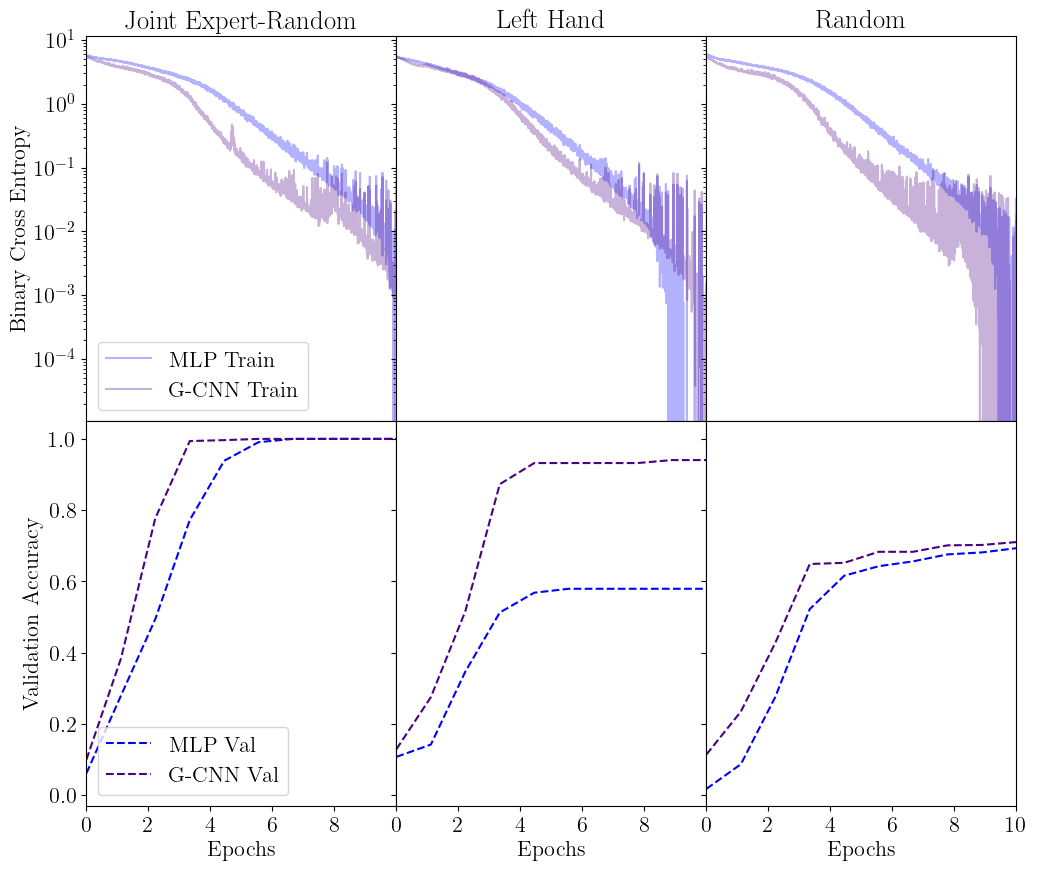

In [11]:
titles = ["Joint Expert-Random", "Left Hand", "Random"]
fig, ax = plt.subplots(2, 3, figsize=(12, 10), sharey="row")
plt.subplots_adjust(hspace=0, wspace=0 )
assert len(sol) == len(hyps) == len(cs)
for sub_sol, hyp, c in zip(sol, hyps, cs):

    for i, ((train_loss, val_loss), tit) in enumerate(zip(sub_sol, titles)):
        if i == 0:
            baseline = jnp.min(train_loss)
        # train_loss= moving_average(train_loss, 10)
        ax[0, i].semilogy(get_x(train_loss, hyp.epochs),train_loss - baseline, label=f"{'MLP' if hyp.model.__name__ == 'CatchModel' else 'G-CNN'} Train", color=c, alpha = 0.3)
        ax[1, i].plot(get_x(val_loss, hyp.epochs), val_loss, label=f"{'MLP' if hyp.model.__name__ == 'CatchModel' else 'G-CNN'} Val", color=c, linestyle="--")
        print(val_loss[-1])
        ax[0, i].set_xlabel("Epochs")
        ax[1, i].set_xlabel("Epochs")
        ax[0, i].set_title(tit)
        ax[0, i].set_xlim(0, EPCH)
        ax[1, i].set_xlim(0, EPCH)
        ax[0, i].set_xticks([])
        # ax[1, i].set_ylim(0, 1)
ax[0, 0].legend(loc="lower left")
ax[1, 0].legend(loc="lower left")
ax[0, 0].set_ylabel("Binary Cross Entropy")
ax[1, 0].set_ylabel("Validation Accuracy")
ax[1, 0].set_xticks(range(0, EPCH, 2))
ax[1, 1].set_xticks(range(0, EPCH, 2))
ax[1, 2].set_xticks(range(0, EPCH + 2, 2));
plt.savefig("../msc_thesis/Figures/transition_model_catch.png")

In [ ]:
rng = jax.random.PRNGKey(42)
key = jax.random.split(rng, 500)
train = jax.jit(ho.make_train(ho.CONFIG, ActorCritic))

result = train(rng)
runner_state= result["runner_state"]


128
976.0


# Catch Playground

In [ ]:
from base_rl.wrappers import FlattenObservationWrapper
env = FlattenObservationWrapper(Catch())
env_params = env.default_params
ts = models[("CatchModel", 2)][1]

KeyError: ('CatchModel', 2)

In [ ]:
def _accuracy(ball_dist, paddle_dist, next_state):
    ball_pred = jnp.zeros_like(ball_dist.probs).at[ball_dist.mode()].set(1.0)
    paddle_pred = (
        jnp.zeros_like(paddle_dist.probs).at[paddle_dist.mode()].set(1.0)
    )
    pred = jnp.concatenate(
        [
            ball_pred.reshape(45),
            paddle_pred.reshape(5),
        ],
        axis=0,
    )
    accuracy = pred == next_state
    return accuracy.all()
# def sample_action(key):
#     action = env.sample_action(key)
#     return action
    

accs = []
num_envs = 100
single_key = jax.random.PRNGKey(0)
key = jax.random.split(single_key, num_envs)
obs, env_state = jax.vmap(env.reset, in_axes=(0, None))(key, env_params)
aply = ts.apply_fn
other_acc = []
policy_aply = jax.vmap(ActorCritic(3).apply, in_axes =(None, 0))

for i in range(100):
    _, single_key = jax.random.split(single_key)
    # action = jax.random.randint(single_key, minval=0, maxval=3, shape=(num_envs,))
    action = policy_aply(expert_params, obs)[0].sample(seed=single_key)
    ball_dist, pad_dist = aply(ts.params, obs, action)
    next_obs, env_state, rew, done, info = jax.vmap(env.step)(key, env_state, action)

    prediction = jax.vmap(_accuracy)(ball_dist, pad_dist, next_obs)
    obs = next_obs
    accs.append(prediction.mean())

print(jnp.stack(accs).mean())



0.61859995
